In [ ]:
from keras.datasets import fashion_mnist
from keras.utils.vis_utils import plot_model
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.optimizers.legacy import SGD
from keras.optimizers.legacy import RMSprop
from keras.optimizers.legacy import Adam
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
import itertools

%matplotlib inline

In [ ]:
tf.random.set_seed(1)

In [ ]:
(X_train, y_train_labels), (X_test, y_test_labels) = fashion_mnist.load_data()
print(X_train.shape, X_test.shape)
print(y_train_labels.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)
(60000,)


Label is 4


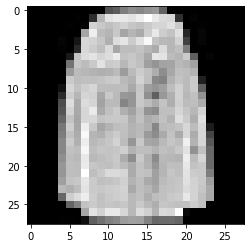

In [ ]:
ind = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[ind], cmap='gray')
print(f'Label is {y_train_labels[ind]}')

In [ ]:
X_train.min(), X_train.max()

(0, 255)

In [ ]:
# Нормировка
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train.min(), X_train.max()

(0.0, 1.0)

In [ ]:
# Вытягивание признаков
X_train = X_train.reshape((-1, 28 * 28))
X_test = X_test.reshape((-1, 28 * 28))

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [ ]:
y_train_labels[:5]

array([9, 0, 0, 3, 0], dtype=uint8)

In [ ]:
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

y_train[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Проверим качество в зависимости от числа нейронов в слое (для 2-х слойной сети).

In [ ]:
%%time
results_num = pd.DataFrame()
n_nums = []
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []


for n_num in list(map(lambda x: 2**x, range(0,10))):
    
    n_nums.append(n_num)
    
    model = Sequential([
        Dense(64, input_shape=(28 * 28,), activation='relu'),
        Dense(n_num, activation='relu'),
        Dense(10, activation='sigmoid')
    ])

    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=64,
                    verbose=1,
                    validation_data=(X_test, y_test)
                    )
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=64)
    train_losses.append(train_loss)
    train_metrics.append(train_metric)
    test_loss, test_metric = model.evaluate(X_test, y_test, batch_size=64)
    test_losses.append(test_loss)
    test_metrics.append(test_metric)
    
    
results_num['n_num'] = n_nums
results_num['train_loss'] = train_losses
results_num['test_loss'] = test_losses
results_num['train_metric'] = train_metrics
results_num['test_metric'] = test_metrics
results_num.sort_values(by='test_metric', ascending=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 dense_2 (Dense)             (None, 10)                20        
                                                                 
Total params: 50,325
Trainable params: 50,325
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 2.0994 - accuracy: 0.1847 - val_loss: 1.9631 - val_accuracy: 0.2122
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 1.8980 - accuracy: 0.2217 - val_loss: 1.8610 - val_accuracy: 0.2288
Epoch 3/5
938/938 [===============

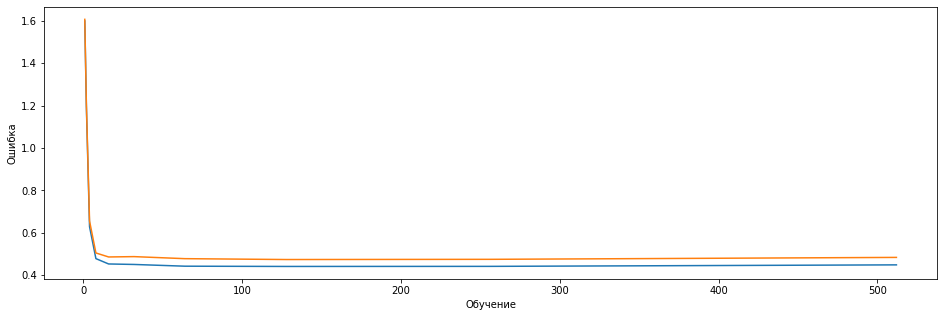

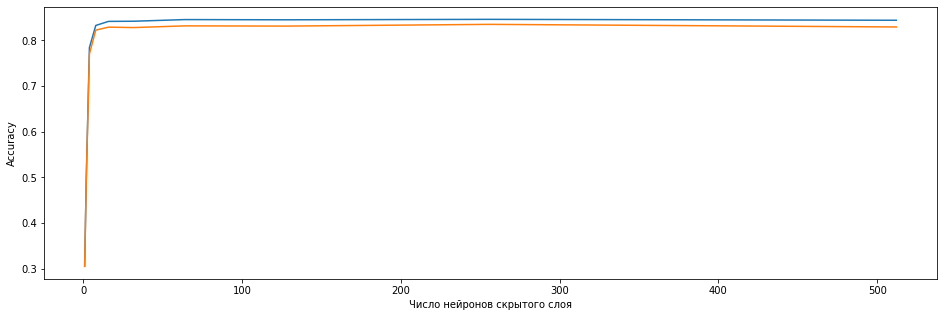

In [ ]:

plt.figure(figsize=(16, 5))
plt.plot(results_num['n_num'],results_num['train_loss'], label='train')
plt.plot(results_num['n_num'],results_num['test_loss'], label='test')
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(results_num['n_num'],results_num['train_metric'], label='train')
plt.plot(results_num['n_num'],results_num['test_metric'], label='test')
plt.xlabel('Число нейронов скрытого слоя')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
%%time
results_layers = pd.DataFrame()
n_nums = [] 
n_layers = []
n_pars = [] 
train_losses = [] 
test_losses = [] 
train_metrics = [] 
test_metrics = [] 

k_dict = {2:128, 3:67, 5:45, 10:30}
for n in [2, 3, 5, 10]:
    
    k = k_dict[n]
    net_size = 64 * 785 + 65 * k + (n - 2) * (k + 1) * k + (k + 1) * 10
    n_nums.append(k) 
    n_pars.append(net_size)
    n_layers.append(n)
    
    model = Sequential()
    model.add(Dense(64, input_shape=(28 * 28,), activation='relu'))
    for i in range(n-1):
        model.add(Dense(k, activation='relu'))
    model.add(Dense(10, activation='sigmoid'))

    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=64,
                    verbose=1,
                    validation_data=(X_test, y_test)
                    )
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=64)
    train_losses.append(train_loss)
    train_metrics.append(train_metric)
    test_loss, test_metric = model.evaluate(X_test, y_test, batch_size=64)
    test_losses.append(test_loss)
    test_metrics.append(test_metric)
    
    
results_layers['n_layer'] = n_layers
results_layers['n_num'] = n_nums
results_layers['n_par'] = n_pars
results_layers['train_loss'] = train_losses
results_layers['test_loss'] = test_losses
results_layers['train_metric'] = train_metrics
results_layers['test_metric'] = test_metrics
results_layers.sort_values(by='test_metric', ascending=False)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                50240     
                                                                 
 dense_31 (Dense)            (None, 128)               8320      
                                                                 
 dense_32 (Dense)            (None, 10)                1290      
                                                                 
Total params: 59,850
Trainable params: 59,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
938/938 [==============================] - 4s 3ms/step - loss: 0.9748 - accuracy: 0.6783 - val_loss: 0.6832 - val_accuracy: 0.7569
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.5886 - accuracy: 0.7993 - val_loss: 0.5675 - val_accuracy: 0.8016
Epoch 3/5
938/938 [============

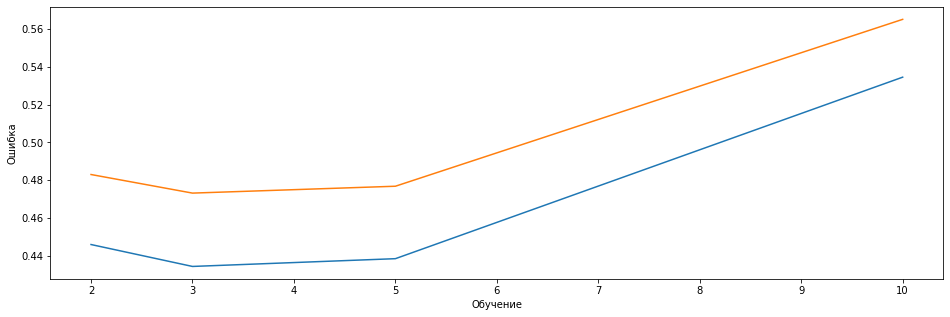

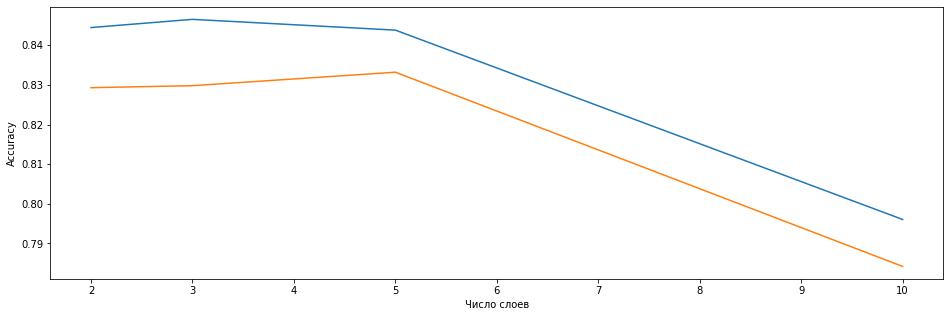

In [ ]:

plt.figure(figsize=(16, 5))
plt.plot(results_layers['n_layer'],results_layers['train_loss'], label='train')
plt.plot(results_layers['n_layer'],results_layers['test_loss'], label='test')
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(results_layers['n_layer'],results_layers['train_metric'], label='train')
plt.plot(results_layers['n_layer'],results_layers['test_metric'], label='test')
plt.xlabel('Число слоев')
plt.ylabel('Accuracy')
plt.show()

Лучшее качество получилось на 5 слоях с 45 нейронами.<br>
На 2, 3 и 5 слоях качество и ошибка примерно соразмерны, на 10 слоях качество прилично просело. Может быть это связано с тем, что количество нейронов скрытых слоев ниже, чтобы сохранить общее количество тренируемых параметров.

Оптимизатор: SGD
Epoch 1/5
938/938 [==============================] - 4s 3ms/step - loss: 1.0901 - accuracy: 0.6052 - val_loss: 0.7811 - val_accuracy: 0.7133
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.6355 - accuracy: 0.7739 - val_loss: 0.5928 - val_accuracy: 0.7954
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.5479 - accuracy: 0.8087 - val_loss: 0.5765 - val_accuracy: 0.7964
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.4970 - accuracy: 0.8261 - val_loss: 0.5113 - val_accuracy: 0.8176
Epoch 5/5
157/157 [==============================] - 0s 3ms/step - loss: 0.4739 - accuracy: 0.8321
Качество на тесте: 0.4738953709602356, 0.832099974155426
Оптимизатор: RMSprop
Epoch 1/5
938/938 [==============================] - 5s 5ms/step - loss: 0.6130 - accuracy: 0.7762 - val_loss: 0.5293 - val_accuracy: 0.8065
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.4149 - accuracy: 0.8475 - 

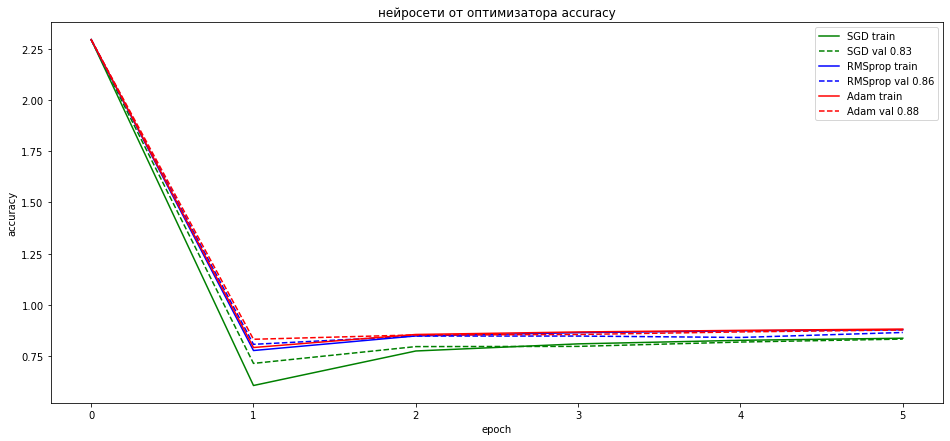

CPU times: user 1min 25s, sys: 6.03 s, total: 1min 31s
Wall time: 1min 17s


In [ ]:
%%time

model = Sequential([
    Dense(64, activation='relu', input_shape=(28 * 28,)),
    Dense(45, activation='relu'),
    Dense(45, activation='relu'),
    Dense(45, activation='relu'),
    Dense(45, activation='relu'),
    Dense(10, activation='sigmoid'),
])

model.save_weights('model_weights.h5')

models = {}

plt.figure(figsize=(16, 7))
colors = ['g', 'b', 'r']

num_epochs = 5
batch_size = 64

epoch = np.arange(num_epochs+1)

for i, i_optim in enumerate([SGD(),
                             RMSprop(),
                             Adam()]):
    print(f'Оптимизатор: {i_optim.get_config()["name"]}')
    
    model_i = Sequential([
        Dense(64, activation='relu', input_shape=(28 * 28,)),
        Dense(45, activation='relu'),
        Dense(45, activation='relu'),
        Dense(45, activation='relu'),
        Dense(45, activation='relu'),
        Dense(10, activation='sigmoid'),
    ])
    
    model_i.load_weights('model_weights.h5')
    
    model_i.compile(
        optimizer=i_optim,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )
    
    h0_train = model_i.evaluate(X_train, y_train, verbose=0)
    h0_val = model_i.evaluate(X_test, y_test, verbose=0)

    h = model_i.fit(X_train, y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    verbose=1)
    
    loss, metric = model_i.evaluate(X_test, y_test, batch_size=64)
    print(f'Качество на тесте: {loss}, {metric}')
    
    models[i_optim.get_config()['name']] = model_i
    
    plt.plot(epoch, ([h0_train[0]] + h.history['accuracy']),
             '-', c=colors[i],
             label=model_i.optimizer.get_config()['name'] + ' train')
    plt.plot(epoch, ([h0_val[0]] + h.history['val_accuracy']),
             '--', c=colors[i],
             label=f'{model_i.optimizer.get_config()["name"]} val {metric:.2f}')

plt.legend()
plt.title('нейросети от оптимизатора accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Итог :

Стохастический градиент является самым низким по качеству оптимизатором , далее идет RMSprop , который борется с ошибкой при увеличении количества эпох.А самым лучшим оптимизатором является Adam , который объединяет в себе сглаживание оптимизации  и уменьшение скорости обучения.   